### Future notes and questions

Think about AM as an optimization problem, does the dynamics that we've used make sense? If good mutations are entropically limited, but every good mutation leads to a promising endpoint, then this may be reasonable. If not all beneficial mutations have high potential to develop further, then maybe it would be better to first build greater diversity with low selection strength (e.g. through abundant T cell help), then turn up the selection strength, analogous to simulated annealing. Connections with Guy's paper. Think about the rate of generating beneficial mutations: rate of mutation $\times$ probability of CDR mutation $\times$ probability affinity-affecting $\times$ probability beneficial. Are AM simulations robust to changes in this probability? If not, then this may be a good reason to think of alternate routines.

### Sanity checking

Let's read in the output from am.py and check the average cycle length, fraction of GCs that were successful versus the ones that died, and the output of all the trajectories.

In [1]:
%matplotlib inline

import csv
import numpy as np
import scipy.stats as st
import operator as op
import matplotlib.pyplot as plot
import seaborn as sns

def selectObservations(observations, keys, values):
    
    # Sanity check
    assert len(keys)==len(values), 'Mistmatched lengths for selectObservations!'
    
    # Return a list of the observations that satisfy a certain set of conditions
    selected = []
    for obs in observations:
        allowed = True
        for i in range(len(keys)):
            if obs[keys[i]]!=values[i]:
                allowed = False
                break
        if allowed: selected.append(obs)
    
    return selected

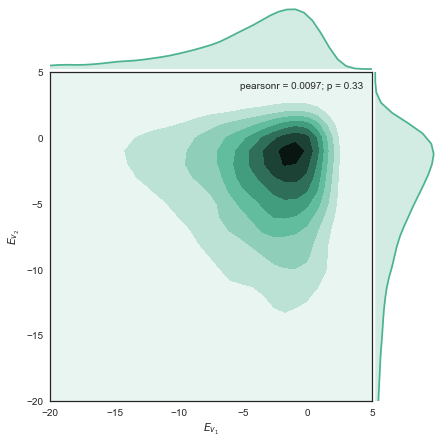

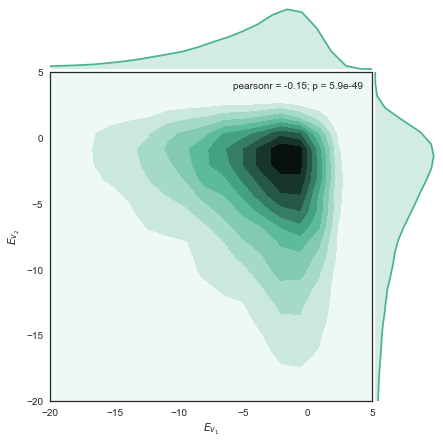

In [34]:
# Plot a historgram and kernel density estimate
#fig, ax = plot.subplots()
#ax.set_xlim([-40, 5])
#for i in range(len(dist.T)):
#    sns.distplot(dist.T[i], bins=range(-50, 10, 1), ax=ax)

nb_Ag  = 2
mu     = 1.9    # lognormal mean
sigma  = 0.5    # lognormal standard deviation
corr   = 0.0    # correlation between antigen variable regions
o      = 3.0    # lognormal offset
mumat  = mu * np.ones(nb_Ag)
sigmat = sigma * np.diag(np.ones(nb_Ag))
for i in range(nb_Ag):
    for j in range(i+1,nb_Ag):
        sigmat[i,j] = sigma * corr
        sigmat[j,i] = sigma * corr

dist = o - np.exp(np.random.multivariate_normal(mumat, sigmat, size=10000))

(sns.jointplot(dist.T[0], dist.T[1], kind="kde", space=0, xlim=[-20,5], ylim=[-20,5], stat_func=st.pearsonr, 
              color="#4CB391").set_axis_labels(r'$E_{v_1}$', r'$E_{v_2}$'));


corr   = -0.2
sigmat = sigma * np.diag(np.ones(nb_Ag))
for i in range(nb_Ag):
    for j in range(i+1,nb_Ag):
        sigmat[i,j] = sigma * corr
        sigmat[j,i] = sigma * corr

dist = o - np.exp(np.random.multivariate_normal(mumat, sigmat, size=10000))

(sns.jointplot(dist.T[0], dist.T[1], kind="kde", space=0, xlim=[-20,5], ylim=[-20,5], stat_func=st.pearsonr, 
              color="#4CB391").set_axis_labels(r'$E_{v_1}$', r'$E_{v_2}$'));

### Test case

No framework mutations, only one round of replication and mutation in the dark zone, and GC ends after the first cycle with selection. CDR mutations have no effect on the energy.

In this case then the number of cells at the start is $2 N_0 = 3072$. The total number that survive mutation and selection and return to the GC should follow a binomial distribution, $N_1 \sim p_{\rm help}\, p_{\rm recycle} \times \text{Binom}(2 N_0, \left(1 - p_{\rm mut}\,p_{\rm lethal}\right)\frac{c}{1+c})$. 

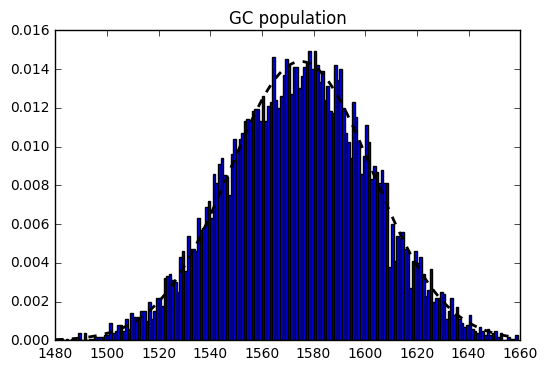

In [2]:
# TEST 1: no changes in energy, one round of replication and SHM, no recycling or selection for T cell help
# PART ONE: total population size

from scipy.stats import binom

reader    = csv.DictReader(open('output-total-test1.csv'))
allTable  = [obs for obs in reader]

nTrials = 10000
nCells  = []
nCycles = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    nCells.append(y[-1])
x = np.arange(1480, 1660, 1)
b = x
n = 3072
p = (1. - (0.2 * 0.3)) * (1.2 / 2.2)
plot.plot(b, binom.pmf(x, n, p), 'k--', linewidth=2, zorder=1)
n, bins, patches = plot.hist(nCells, b, normed=True)
plot.title('GC population')
plot.show()

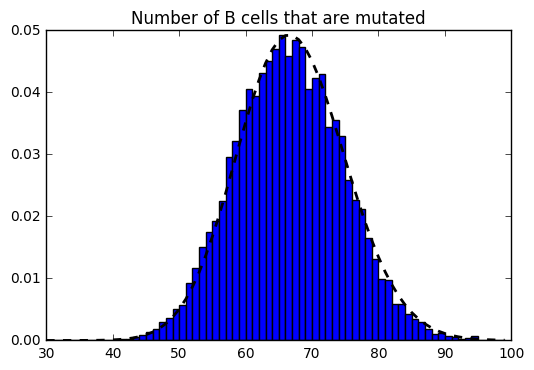

In [4]:
# PART TWO: number of affinity-affecting mutations

reader    = csv.DictReader(open('output-memory-test1.csv'))
cellTable = [obs for obs in reader]

nTrials  = 10000
nMutated = [0 for i in range(nTrials)]
for o in cellTable:
    if int(o['mutations'])==1: nMutated[int(o['trial'])] += int(o['number'])

fig = plot.figure()
x = np.arange(30, 100, 1)
b = x
n = 3072
p = (0.2 * 0.2) * (1.2 / 2.2)
plot.plot(b, binom.pmf(x, n, p), 'k--', linewidth=2, zorder=1)
n, bins, patches = plot.hist(nMutated, b, normed=True)
plot.title('Number of B cells that are mutated')
plot.show()

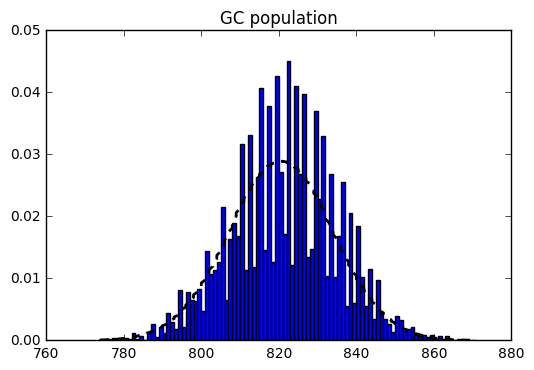

In [21]:
# TEST 2: no mutation, one round of replication and SHM, standard recycling and selection for T cell help
# PART ONE: total population size

reader    = csv.DictReader(open('output-total-test2.csv'))
allTable  = [obs for obs in reader]

nTrials = 10000
#nCells  = []
#nCycles = []

fig = plot.figure()
#for i in range(nTrials):
#    tTable = selectObservations(allTable, ['trial'], [str(i)])
#    x      = [int(o['cycle'])           for o in tTable]
#    y      = [int(o['number recycled']) for o in tTable]
#    nCells.append(y[-1])
x = np.arange(1580, 1780, 1)
b = [int(i) for i in np.floor(0.7 * 0.7 * x)] 
n = 3072
p = 1.2 / 2.2
plot.plot(b, 2.*binom.pmf(x, n, p), 'k--', linewidth=2, zorder=1)
n, bins, patches = plot.hist(nCells, np.arange(np.min(b),np.max(b)+1,1), normed=True)
plot.title('GC population')
plot.show()

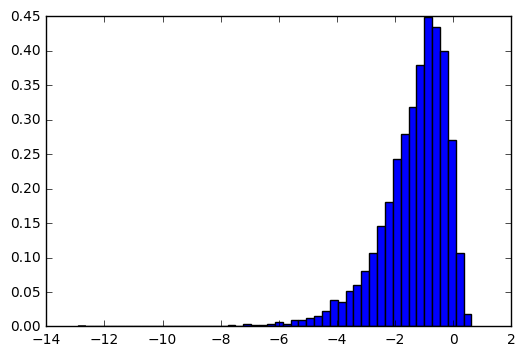

5.21
(-1.3665643308988598, -1.1114580379295769)


In [7]:
x = 0.3*(3 - np.exp(np.random.normal(1.9, 0.5, 10000)))
fig = plot.figure()
n, bins, patches = plot.hist(x, 50, normed=1)
plot.show()

print(np.sum(x>0)/float(len(x)) * 100.)
print(np.mean(x),np.median(x))

In [3]:
mu    = np.array([1.9, 1.9])
sigma = 0.5 * np.array([[1., -0.5],[-0.5, 1.]])
x = 0.3*(np.array([3,3]) - np.exp(np.random.multivariate_normal(mu, sigma)))
print(x)

[-0.2867864 -4.4884868]


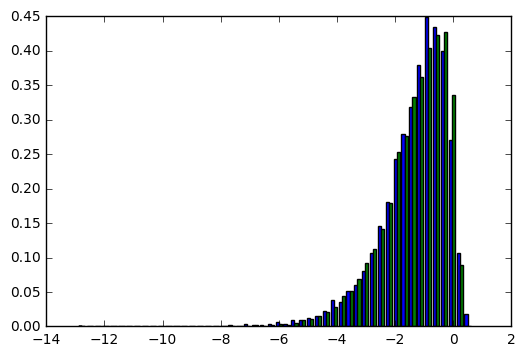

5.21
(-1.3665643308988598, -1.1114580379295769)


In [8]:
from scipy.stats import genextreme

c      = 0.7  # Generalized extreme value (GEV) distribution shape parameter
scale  = 1.2  # GEV scale parameter
loc    = -1.5 # GEV location parameter
gevrnd = genextreme(c=c, scale=scale, loc=loc)

mu = -1.5
sigma = 1.2
kappa = -0.7
c = 1.2
es = 0.05

y = gevrnd.rvs(10000)
fig = plot.figure()
n, bins, patches = plot.hist([x,y], 50, normed=1)
plot.show()

print(np.sum(x>0)/float(len(x)) * 100.)
print(np.mean(x),np.median(x))

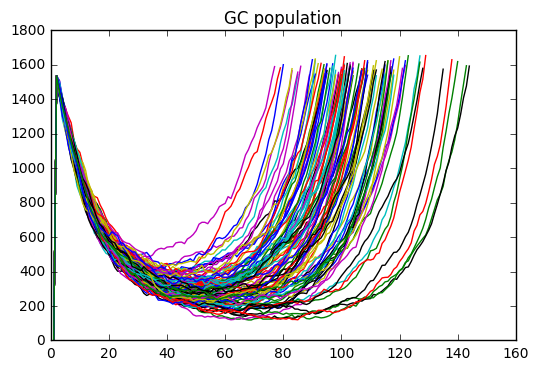

100 out of 100 GCs succeeded.


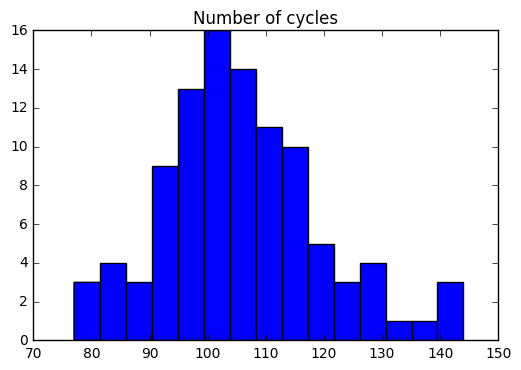

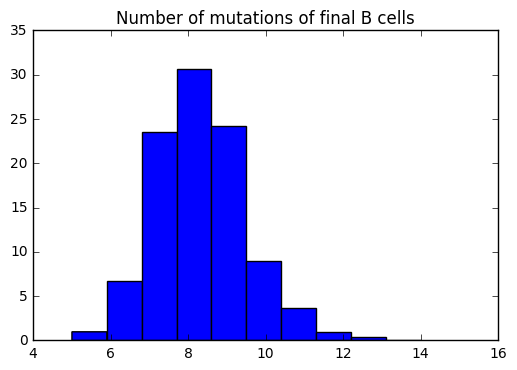

In [14]:
# lognormal
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

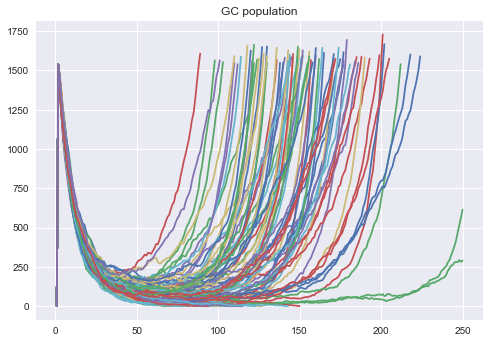

75 out of 100 GCs succeeded.


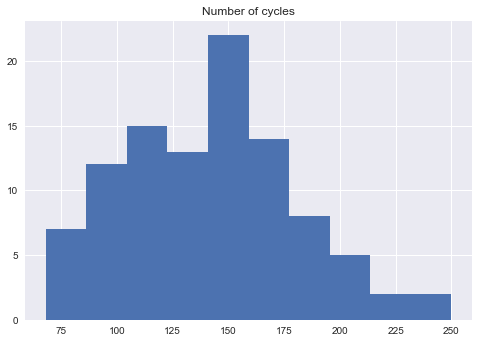

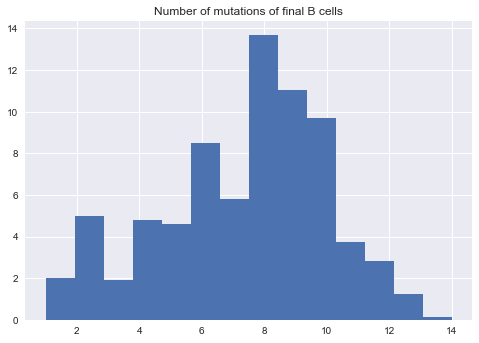

In [9]:
# lognormal
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 10)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

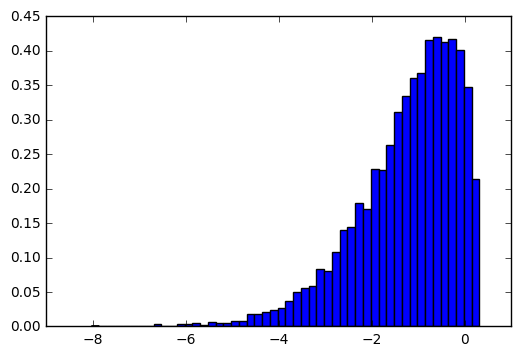

0.0859


In [12]:
from scipy.stats import genextreme

c      = 0.7  # Generalized extreme value (GEV) distribution shape parameter
scale  = 1.2  # GEV scale parameter
loc    = -1.4 # GEV location parameter
gevrnd = genextreme(c=c, scale=scale, loc=loc)

y = gevrnd.rvs(10000)
fig = plot.figure()
n, bins, patches = plot.hist(y, 50, normed=1)
plot.show()

print(float(np.sum(y>0))/float(len(y)))

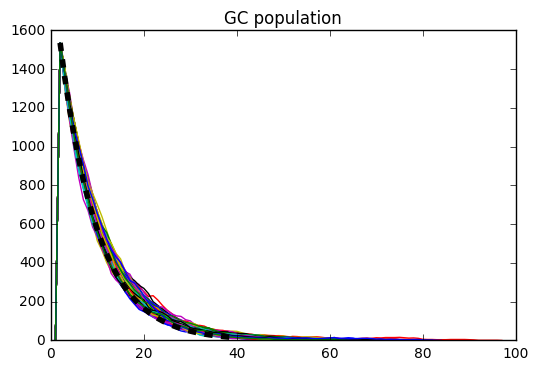

0 out of 100 GCs succeeded.


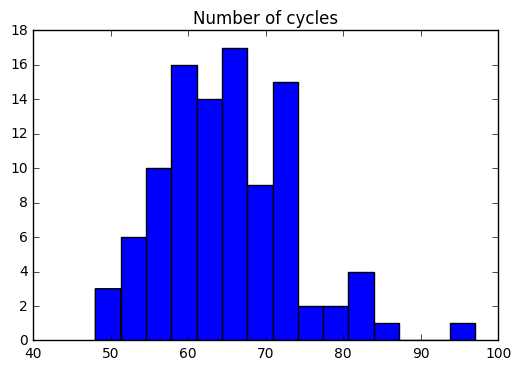

ValueError: zero-size array to reduction operation maximum which has no identity

In [45]:
# Sanity checking
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
x = np.arange(2, 40, 1)
y = 1536. * (4 * 0.9 * 0.9 * 0.5 * 1.0 * (1.2 / 2.2))**(x - 2.)
plot.plot(x, y, color='black', lw=4, ls='--')
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

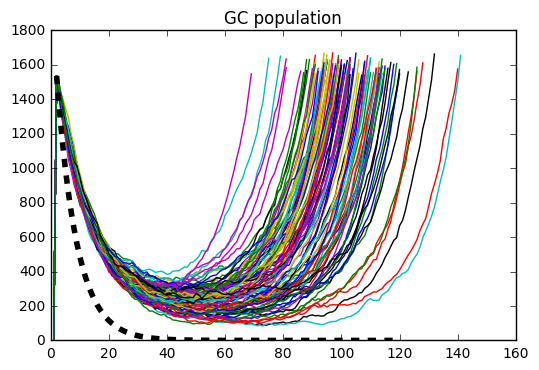

100 out of 100 GCs succeeded.


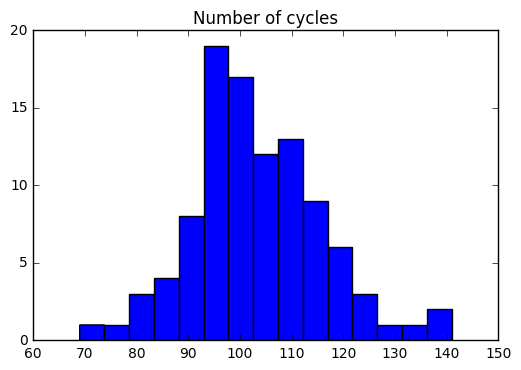

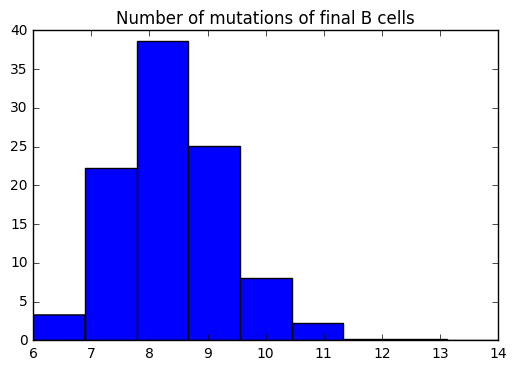

In [40]:
# GEV
reader    = csv.DictReader(open('output-total.csv'))
allTable  = [obs for obs in reader]
reader    = csv.DictReader(open('output-memory.csv'))
cellTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
x = np.arange(2, 120, 1)
y = 1536. * (4 * 0.9 * 0.9 * 0.7 * 0.7 * (1.2 / 2.2))**(x - 2.)
plot.plot(x, y, color='black', lw=4, ls='--')
plot.title('GC population')
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles, 15)
plot.title('Number of cycles')
plot.show()

nMutations = []
weights    = []
for i in range(nTrials):
    tTable = selectObservations(cellTable, ['trial'], [str(i)])
    total  = float(np.sum([int(o['number']) for o in tTable]))
    for o in tTable:
        nMutations.append(int(o['mutations']))
        weights.append(float(o['number'])/total)

fig = plot.figure()
n, bins, patches = plot.hist(nMutations, 1 + np.max(nMutations) - np.min(nMutations), weights=weights)
plot.title('Number of mutations of final B cells')
plot.show()

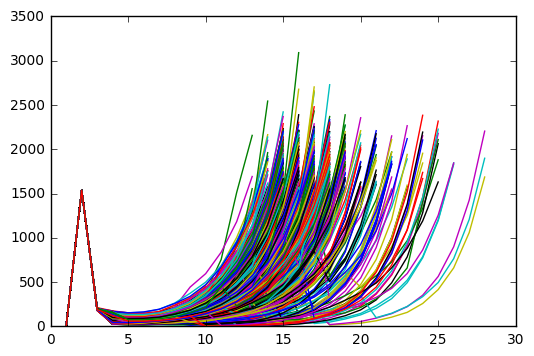

499 out of 500 GCs succeeded.


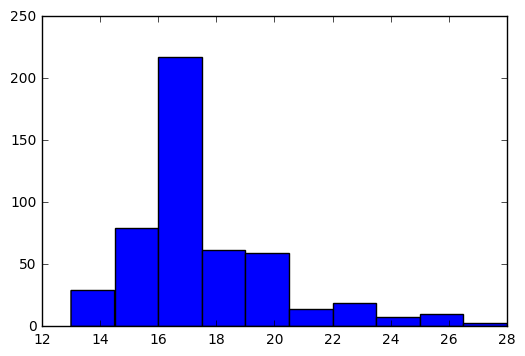

In [10]:
reader   = csv.DictReader(open('output-total.csv'))
allTable = [obs for obs in reader]

nTrials  = 500
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles)
plot.show()

# nb_Ag = 1

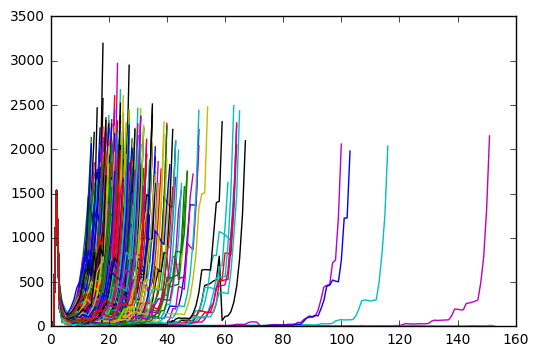

489 out of 500 GCs succeeded.


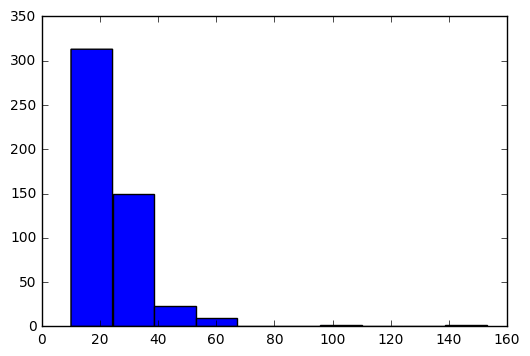

In [12]:
reader   = csv.DictReader(open('output-total.csv'))
allTable = [obs for obs in reader]

nTrials  = 500
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles)
plot.show()

# nb_Ag = 2, else same as above

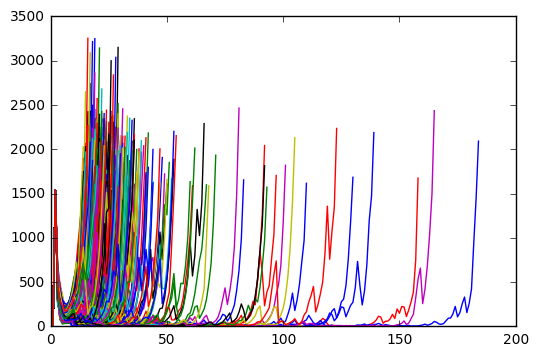

488 out of 500 GCs succeeded.


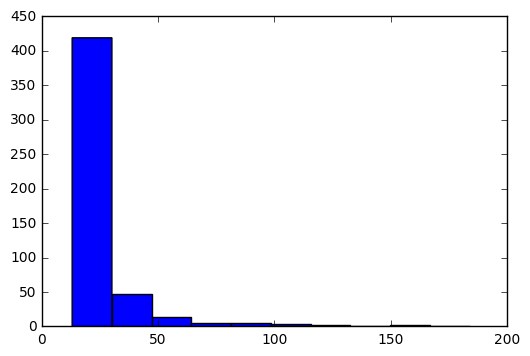

In [13]:
reader   = csv.DictReader(open('output-total.csv'))
allTable = [obs for obs in reader]

nTrials  = 500
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles)
plot.show()

# nb_Ag = 3, else same as above

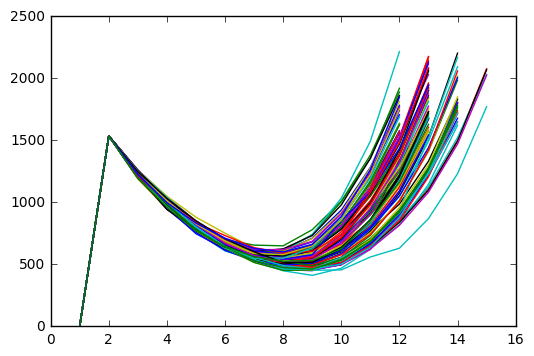

100 out of 100 GCs succeeded.


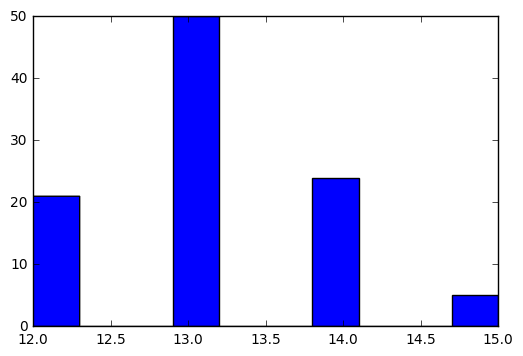

In [14]:
reader   = csv.DictReader(open('output-total.csv'))
allTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles)
plot.show()

# nb_Ag = 3, modified Ag_thresh

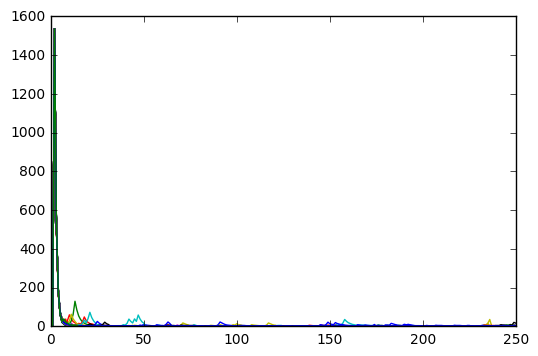

22 out of 100 GCs succeeded.


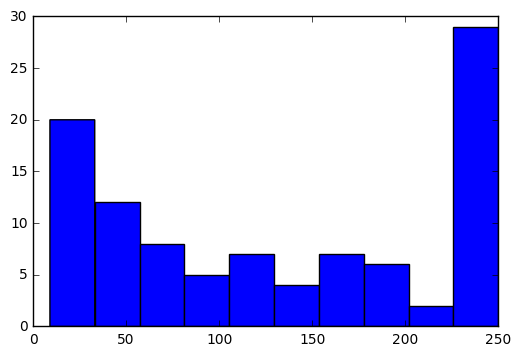

In [18]:
reader   = csv.DictReader(open('output-total.csv'))
allTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles)
plot.show()

# nb_Ag = 1, modified Ag_thresh

The maximal growth rate $m$ per cycle of a homogeneous population of B cells in the germinal center (GC) is given roughly by 

$$ m = 4 (1-\mu)^2 r \,, $$

where $\mu$ is the mutation rate (and we assume that most mutants die) and $r$ is the recycling rate. The leading factors of 4 and $(1-\mu)^2$ are present because the cells undergo two rounds of division and mutation per GC cycle.

In the earliest stages of the GC the initial founder population decays by a factor of $m s_0$ per cycle, where $s_0$ is the fraction of founder B cells that successfully internalize antigen and thus survive this selection step. 

How many beneficial mutants are generated from the founder population until it dies out? The rough number of cycles $c$ needed for the founders to die out is

$$ c = -\frac{\log{N_0}}{\log{m s_0}} \,, $$

where $N_0$ is the size of the starting population of B cells. If the B cell population in cycle $i$ is $N_i$, then the rough number of beneficial mutants produced in that cycle is $\left(2 + 4(1-\mu)\right)N_i \mu^+$, where $\mu^+$ is the probability of a beneficial mutation. The total number of beneficial mutants produced is then

\begin{align}\begin{aligned}
\left(2 + 4(1-\mu)\right)\mu^+ \sum_{k=0}^{c-1} N_0 \left(m s_0\right)^k &= \left(2 + 4(1-\mu)\right)\mu^+ N_0 \frac{1-\left(m s_0\right)^c}{1-m s_0} \\
&\approx \left(2 + 4(1-\mu)\right)\mu^+ \frac{N_0 - 1}{1-m s_0}\,.
\end{aligned}\end{align}



In [53]:
N0           = 1536
p_mut        = 0.2
p_CDR        = 0.7
p_FR         = 1 - p_CDR
p_CDR_lethal = 0.3
p_CDR_bad    = 0.15
p_FR_lethal  = 0.5
help_cutoff  = 0.70
p_recycle    = 0.70
energy_scale = 0.07
conc         = 1.15
p_bind0      = conc / (1 + conc)
p_death      = p_mut * ((p_CDR * (p_CDR_lethal + p_CDR_bad)) + (p_FR * p_FR_lethal))
alpha        = 4 * (1 - p_death) * (1 - p_death) * help_cutoff * p_recycle
n_mut_init   = (2 + (4 * (1 - p_death))) * (N0 - 1) / (1 - (alpha * p_bind0))

Eh  = (-(np.log(alpha-1)+np.log(conc))/energy_scale)
cyc = -np.log(N0)/np.log(alpha * p_bind0)

print('energy required for homeostasis Eh = %lf' % Eh)
print('number of cycles before founders die out = %lf' % cyc)
print(r'$\langle n_{mut}\rangle$ initial = %lf $\times \mu_+$' % n_mut_init)

energy required for homeostasis Eh = 5.008867
number of cycles before founders die out = 49.578225
$\langle n_{mut}\rangle$ initial = 62802.570181 $\times \mu_+$


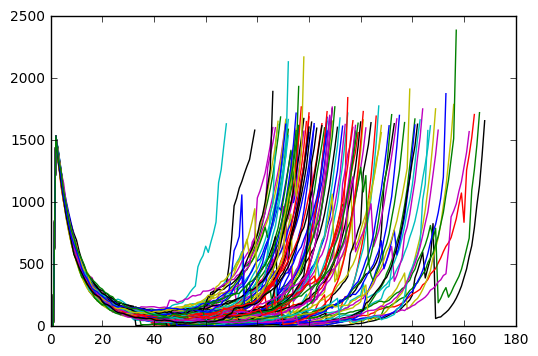

92 out of 100 GCs succeeded.


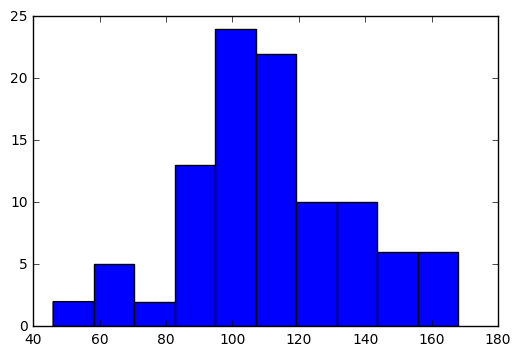

In [28]:
reader   = csv.DictReader(open('output-total.csv'))
allTable = [obs for obs in reader]

nTrials  = 100
nSucceed = 0
nCycles  = []

fig = plot.figure()
for i in range(nTrials):
    tTable = selectObservations(allTable, ['trial'], [str(i)])
    x      = [int(o['cycle'])           for o in tTable]
    y      = [int(o['number recycled']) for o in tTable]
    if y[-1]>0: nSucceed += 1
    nCycles.append(x[-1])
    plot.plot(x, y)
plot.show()

print('%d out of %d GCs succeeded.' % (nSucceed, nTrials))

fig = plot.figure()
n, bins, patches = plot.hist(nCycles)
plot.show()